

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:

# ----------------
# Packages Update
# ----------------

# General libraries
import sys
import os
import glob
import pandas as pd
import numpy as np
import csv
import time
from datetime import datetime
import pickle
import gc

from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestClassifier

import shap

import tools_dataframe
import tools_preprocessing
import tools_feat_engineering


# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Validation code PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

# Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings(action='once')
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ValueError)
simplefilter(action='ignore', category=UserWarning)

# Versions
print('Version of used libraries :')

print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Dataframe tools      : ' + tools_dataframe.__version__)
now = datetime.now().isoformat()
print('\nLaunched on : ' + now)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Version of used libraries :
Python                : 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.24.3
Pandas                : 1.5.3
Dataframe tools      : 0.0.0

Launched on : 2023-08-08T16:04:04.503335



<a id='USED_PARAMETERS'></a>


<br>


---
---

<font size="+1"> **PARAMETERS USED IN THIS NOTEBOOK** </font>

---


In [2]:
# Parameters used in this notebook

seed = 84

In [3]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None}

for key, value in dico_pd_option.items():
    pd.set_option(key, value)

In [4]:
# Define the folder containing the files with the project data
P7_source = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/p7_source"

os.chdir(P7_source)

2:80: E501 line too long (85 > 79 characters)



<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<center><img src="./img/logo_projet.png" style="height: 250px;"/></center>

**Prêt à dépenser** wants to implement a **credit scoring tool to calculate the probability of a customer repaying their loan**, and then **classify the application as either granted or refused credit**. It therefore wants to develop a classification algorithm based on a variety of data sources (behavioural data, data from other financial institutions, etc.).

This notebook includes the **feature selection**.
Consists of finding a subset of relevant variables in a high-dimensional space. The loss of information caused by removing all the other variables must therefore be minimised.<br>
The aim is to identify the optimum number of variables. I.e., the one that considers the most important variables for the different families of algorithms and results in reasonable calculation times, without affecting the performance of the models.


## <font color = '#0085dd'>**Table of content**</font>


[LOADING THE LIBRARIES](#LOADING_LIBRARIES)<br>

[Parameters used in this notebook](#USED_PARAMETERS)<br>

---


[**Loading datasets**](#datasets_loading)
 * [Looking for empty features](#empty_feat)
 * [Scaling data](#scaling_data)<br>
<br>

[**Feature selection**](#feature_selection)
 * [Feature Importance using LightGBM](#feat_imp_LGBM)
 * [Feature Importance using Random Forest](#feat_imp_RandomForest)<br>
 * [Bilan Feature Selection](#bilan_feat_select_LGB)
   * [Features with a combined normalized importance under 0.2 will be removed](#select_combined_normalized_importance_over_02)
   * [Features with a combined normalized importance under 0.5 will be removed](#select_combined_normalized_importance_over_05)
   * [15 highest values of combined normalized importance will be selected](#select_combined_normalized_importance_15highest)
   * [10 best values of normalized importance from LightGBM and RandomForest will be selected](#select_combined_10best_lgbm_rf)
   * [25 best values of normalized importance from LightGBM and RandomForest will be selected](#select_combined_25best_lgbm_rf)
   * [Summary](#feat_select_summary)
<br>

---


<a id='datasets_loading'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Loading datasets** </span></span>


In this section, we will try to reduce the number of features, in such a way that it doesn't have a negative impact on the performance of the model.

In [5]:
# Load de datasets after feature engineering
path_train_dataset_after_feat_eng = \
    '../P7_scoring_credit/preprocessing/final_train_data.pkl'

with open(path_train_dataset_after_feat_eng, 'rb') as f:
    final_train_data = pickle.load(f)

In [6]:
# Load de datasets after feature engineering
path_test_dataset_after_feat_eng = \
    '../P7_scoring_credit/preprocessing/final_test_data.pkl'

with open(path_test_dataset_after_feat_eng, 'rb') as f:
    final_test_data = pickle.load(f)

In [7]:
# extracting the SK_ID_CURR from training and test data
skid_train = final_train_data['SK_ID_CURR']
skid_test = final_test_data['SK_ID_CURR']

# extracting the class labels for training data
target_train = final_train_data['TARGET']

In [8]:
# Create a copy of dataframes
train_data = final_train_data.copy()
test_data = final_test_data.copy()

# Dataframes alignement
train_data, test_data = train_data.align(test_data,
                                         join='inner', axis=1)
# Remove ID columns
train_data = train_data.drop(columns=['SK_ID_CURR'])
test_data = test_data.drop(columns=['SK_ID_CURR'])

print(f'train_data : {train_data.shape}')
print(f'test_data : {test_data.shape}')

train_data : (307511, 417)
test_data : (48744, 417)


<a id='empty_feat'></a>

## <span style='background:#0085dd'><span style='color:white'>Looking for empty features</span></span>

In [9]:
print(f"Initial size of train_data {train_data.shape}")
print(f"\nInitial size of test_data {test_data.shape}")

Initial size of train_data (307511, 417)

Initial size of test_data (48744, 417)


Here, empty features refer to those features which have just one unique value. These features are useless for the classifiers, as they do not contain any information.

In [10]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <= 1:
        empty_columns.append(col)

print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis=1)
test_data = test_data.drop(empty_columns, axis=1)

There are 22 columns with just 1 unique value
Removing these from dataset


<a id='scaling_data'></a>

## <span style='background:#0085dd'><span style='color:white'>Scaling data</span></span>

In [11]:
# Extracting column names
train_columns = train_data.columns.tolist()
test_columns = test_data.columns.tolist()

In [12]:
# standardizing the data
scaler = StandardScaler()

train_data_std = scaler.fit_transform(train_data)
test_data_std = scaler.fit_transform(test_data)

# replacing nan values with 0
train_data_std[np.isnan(train_data_std)] = 0
test_data_std[np.isnan(test_data_std)] = 0

In [13]:
# Reconstruct datasets
train_data_std = pd.DataFrame(train_data_std, columns=train_columns)
test_data_std = pd.DataFrame(test_data_std, columns=test_columns)

<a id='feature_selection'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Feature selection** </span></span>


<a id='feat_imp_LGBM'></a>

## <span style='background:#0085dd'><span style='color:white'>Feature Importance using LightGBM</span></span>

In [14]:
lGBM_train_data = train_data_std.copy()
lGBM_test_data = test_data_std.copy()

In [15]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_lGBM = np.zeros(lGBM_train_data.shape[1])

# Create the model with several hyperparameters
model_lGBM = lgb.LGBMClassifier(objective='binary',
                                boosting_type='goss',
                                n_estimators=10000,
                                class_weight='balanced',
                                verbose=-100)

In [16]:
# Split en jeux d'entraînement et de validation
train_features, valid_features, train_y, valid_y = \
    train_test_split(lGBM_train_data, target_train,
                     test_size=0.25, random_state=seed)

# Entraînement en utilisant early stopping
model_lGBM.fit(train_features, train_y)

# Sauvegarde des features importances
feature_importances_lGBM += model_lGBM.feature_importances_

In [17]:
# Create a dataframe for feature importance information
df_feat_importance_lGBM = \
    pd.DataFrame({'feature': list(lGBM_train_data.columns),
                  'lGBM_importance': feature_importances_lGBM})

# Normalize the feature importances
df_feat_importance_lGBM['lGBM_importance_normalized'] = \
    (df_feat_importance_lGBM['lGBM_importance']
     - df_feat_importance_lGBM['lGBM_importance'].min()) \
    / (df_feat_importance_lGBM['lGBM_importance'].max()
       - df_feat_importance_lGBM['lGBM_importance'].min())

df_feat_importance_lGBM = df_feat_importance_lGBM\
    .sort_values('lGBM_importance_normalized',
                 ascending=False).reset_index(drop=True)

# Create a column with the ranking position
df_feat_importance_lGBM["fi_lGBM_ranking"] = df_feat_importance_lGBM.index

df_feat_importance_lGBM.head(10)

,feature,lGBM_importance,lGBM_importance_normalized,fi_lGBM_ranking
0,DAYS_REGISTRATION,4131.0,1.0000,0
1,CREDIT_ANNUITY_RATIO,3899.0,0.9438,1
2,DAYS_ID_PUBLISH,3886.0,0.9407,2
3,EXT_SOURCE_2,3833.0,0.9279,3
4,DAYS_BIRTH,3687.0,0.8925,4
5,EXT_SOURCE_MEAN,3686.0,0.8923,5
6,CREDIT_INCOME_RATIO,3368.0,0.8153,6
7,OBS_30_CREDIT_RATIO,3309.0,0.8010,7
8,DAYS_LAST_PHONE_CHANGE,3134.0,0.7587,8
9,INCOME_EXT_RATIO,3030.0,0.7335,9


In [18]:
# Find features with zero importance
zero_features = \
    list(df_feat_importance_lGBM[df_feat_importance_lGBM['lGBM_importance']
                                 == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')

37 variables avec 0.0 importance :



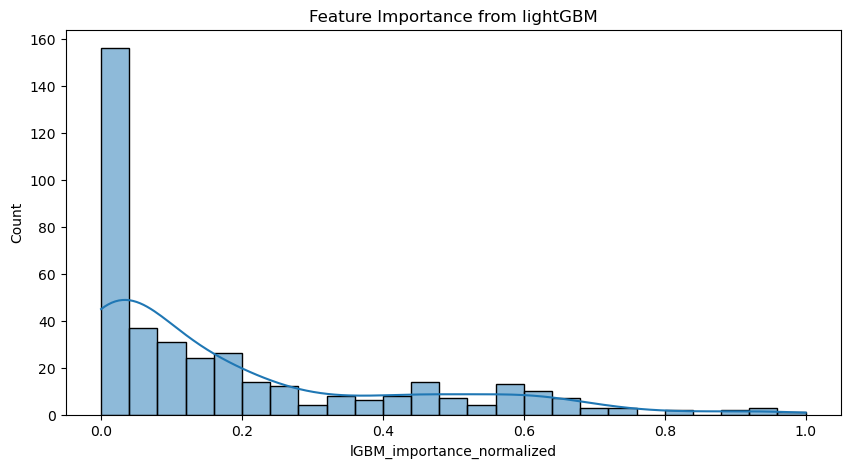

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df_feat_importance_lGBM, x="lGBM_importance_normalized",
             bins=25, kde=True)
plt.title('Feature Importance from lightGBM')
plt.show()

<a id='feat_imp_RandomForest'></a>

## <span style='background:#0085dd'><span style='color:white'>Feature Importance using Random Forest</span></span>

In [20]:
RF_train_data = train_data.copy()
RF_test_data = test_data.copy()

In [21]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_RF = np.zeros(RF_train_data.shape[1])

# Create the model with several hyperparameters
randomForest = RandomForestClassifier(random_state=seed,
                                      class_weight='balanced')

In [22]:
# Split en jeux d'entraînement et de validation
train_features, valid_features, train_y, valid_y = \
    train_test_split(RF_train_data, target_train,
                     test_size=0.25, random_state=seed)

# Entraînement
randomForest.fit(train_features, train_y)

RandomForestClassifier(class_weight='balanced', random_state=84)

In [23]:
# Sauvegarde des features importances
feature_importances_RF += randomForest.feature_importances_

In [24]:
# Create a dataframe with feature importance information
df_feat_importance_RF = \
    pd.DataFrame({'feature': list(RF_train_data.columns),
                  'RF_importance': feature_importances_RF})

# Normalize feature importances
df_feat_importance_RF['RF_importance_normalized'] = \
    (df_feat_importance_RF['RF_importance']
     - df_feat_importance_RF['RF_importance'].min()) \
    / (df_feat_importance_RF['RF_importance'].max()
       - df_feat_importance_RF['RF_importance'].min())

df_feat_importance_RF = df_feat_importance_RF\
    .sort_values('RF_importance_normalized',
                 ascending=False).reset_index(drop=True)

# Create a column with the ranking position
df_feat_importance_RF["fi_RF_ranking"] = df_feat_importance_RF.index

df_feat_importance_RF.head(10)

,feature,RF_importance,RF_importance_normalized,fi_RF_ranking
0,EXT_SOURCE_MEAN,0.0440,1.0000,0
1,EXT_SOURCE_2,0.0293,0.6649,1
2,EXT_SOURCE_3,0.0199,0.4521,2
3,INCOME_EXT_RATIO,0.0121,0.2747,3
4,EXT_SOURCE_1,0.0111,0.2522,4
5,CAR_EMPLOYED_RATIO,0.0105,0.2398,5
6,CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_OVERALL,0.0101,0.2293,6
7,CREDIT_ANNUITY_RATIO,0.0093,0.2117,7
8,DAYS_CREDIT_MEAN_OVERALL,0.0093,0.2117,8
9,DAYS_EMPLOYED,0.0093,0.2111,9


In [25]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_feat_importance_RF[df_feat_importance_RF['RF_importance']
                               == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
# zero_features

10 variables avec 0.0 importance :



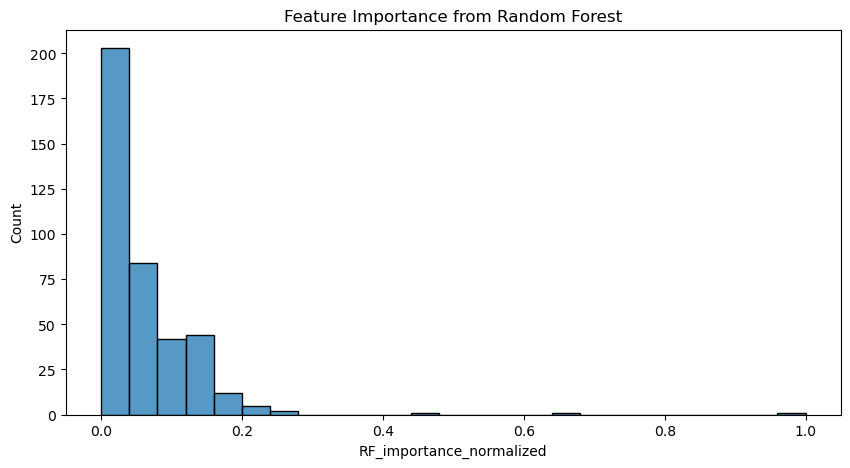

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(df_feat_importance_RF, x="RF_importance_normalized", bins=25)
plt.title('Feature Importance from Random Forest')
plt.show()

<a id='bilan_feat_select_LGB'></a>

## <span style='background:#0085dd'><span style='color:white'>Bilan Feature Selection</span></span>

In [27]:
df_feat_importances  = df_feat_importance_lGBM.merge(df_feat_importance_RF,
                                                     how='outer', on="feature")
df_feat_importances

,feature,lGBM_importance,lGBM_importance_normalized,fi_lGBM_ranking,RF_importance,RF_importance_normalized,fi_RF_ranking
0,DAYS_REGISTRATION,4131.0,1.0000,0,7.5161e-03,1.7085e-01,19
1,CREDIT_ANNUITY_RATIO,3899.0,0.9438,1,9.3139e-03,2.1172e-01,7
2,DAYS_ID_PUBLISH,3886.0,0.9407,2,7.6548e-03,1.7400e-01,17
3,EXT_SOURCE_2,3833.0,0.9279,3,2.9251e-02,6.6491e-01,1
4,DAYS_BIRTH,3687.0,0.8925,4,8.7083e-03,1.9795e-01,10
5,EXT_SOURCE_MEAN,3686.0,0.8923,5,4.3992e-02,1.0000e+00,0
6,CREDIT_INCOME_RATIO,3368.0,0.8153,6,7.6383e-03,1.7363e-01,18
7,OBS_30_CREDIT_RATIO,3309.0,0.8010,7,6.7986e-03,1.5454e-01,22
8,DAYS_LAST_PHONE_CHANGE,3134.0,0.7587,8,7.8181e-03,1.7772e-01,15
9,INCOME_EXT_RATIO,3030.0,0.7335,9,1.2087e-02,2.7474e-01,3


1:20: E221 multiple spaces before operator


In [28]:
# Combine lGBM anf RF feature importances
df_feat_importances["combined_importance"] = \
    df_feat_importances["lGBM_importance_normalized"] \
    + df_feat_importances["RF_importance_normalized"]

df_feat_importances.sort_values(by="combined_importance",
                                ascending=False).head(15)

,feature,lGBM_importance,lGBM_importance_normalized,fi_lGBM_ranking,RF_importance,RF_importance_normalized,fi_RF_ranking,combined_importance
5,EXT_SOURCE_MEAN,3686.0,0.8923,5,0.0440,1.0000,0,1.8923
3,EXT_SOURCE_2,3833.0,0.9279,3,0.0293,0.6649,1,1.5928
0,DAYS_REGISTRATION,4131.0,1.0000,0,0.0075,0.1709,19,1.1709
1,CREDIT_ANNUITY_RATIO,3899.0,0.9438,1,0.0093,0.2117,7,1.1556
2,DAYS_ID_PUBLISH,3886.0,0.9407,2,0.0077,0.1740,17,1.1147
4,DAYS_BIRTH,3687.0,0.8925,4,0.0087,0.1980,10,1.0905
22,EXT_SOURCE_3,2636.0,0.6381,22,0.0199,0.4521,2,1.0902
9,INCOME_EXT_RATIO,3030.0,0.7335,9,0.0121,0.2747,3,1.0082
6,CREDIT_INCOME_RATIO,3368.0,0.8153,6,0.0076,0.1736,18,0.9889
7,OBS_30_CREDIT_RATIO,3309.0,0.8010,7,0.0068,0.1545,22,0.9556


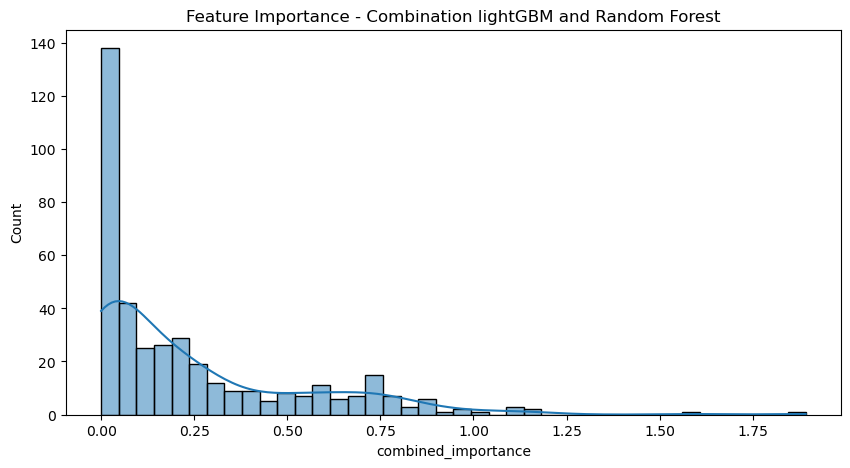

In [29]:
# Graphical representation of combined lGBM and RF normalized importances
plt.figure(figsize=(10, 5))
sns.histplot(df_feat_importances, x="combined_importance", bins=40, kde=True)
plt.title('Feature Importance - Combination lightGBM and Random Forest')
plt.show()

<a id='select_combined_normalized_importance_over_02'></a>

### <span style='background:#0075bc'><span style='color:white'>Features with a combined normalized importance under 0.2 will be removed</span></span>

In [30]:
df_feat_imp_selec = df_feat_importances.copy()
df_feat_imp_lGBM_selec = df_feat_importance_lGBM.copy()
df_feat_imp_RF_selec = df_feat_importance_RF.copy()

In [31]:
df_feat_importances.shape

(395, 8)

In [32]:
# Features with a combined normalized importance under 0.2 will be removed
to_remove02 = \
    df_feat_imp_selec.loc[df_feat_imp_selec["combined_importance"] <= 0.20]
print(f"Features to remove", to_remove02.shape[0])

# Feaatures with a combined normalized importance over 0.2 will be selected
to_select02 = \
    df_feat_imp_selec.loc[df_feat_imp_selec["combined_importance"] > 0.20]

to_select02.shape
print(f"Selected features", to_select02.shape[0])

Features to remove 240
Selected features 155


In [33]:
# Prepare data for verification
to_remove02["Action"] = "Delete"
to_select02["Action"] = "Select"

features_action02 = [to_select02[["feature", "Action"]],
                     to_remove02[["feature", "Action"]]]
action_features02 = pd.concat(features_action02)

df_feat_imp_selec_02_lGBM = df_feat_imp_lGBM_selec.merge(action_features02,
                                                         on="feature")
df_feat_imp_selec_02_RF = df_feat_imp_RF_selec.merge(action_features02,
                                                     on="feature")

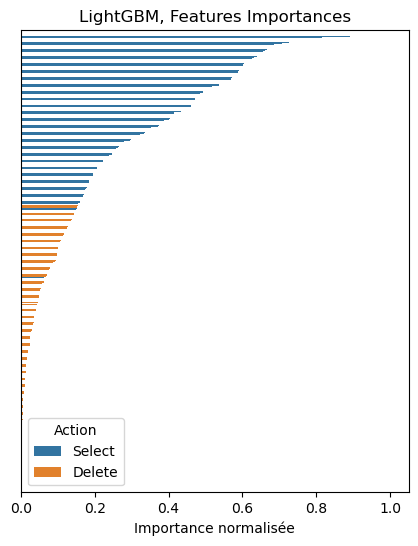

In [34]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_selec_02_lGBM,
                 x="lGBM_importance_normalized", y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('LightGBM, Features Importances')
plt.show()

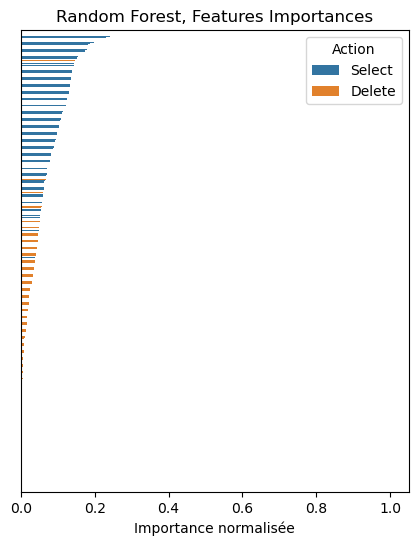

In [35]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_selec_02_RF, x="RF_importance_normalized",
                 y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('Random Forest, Features Importances')
plt.show()

In [36]:
train_data_fs_02 = train_data_std.copy()
test_data_fs_02 = test_data_std.copy()

# Remove features with a combined normalized importance under 0.2
train_data_fs_02 = \
        train_data_fs_02.drop(columns=to_remove02['feature'].tolist())
test_data_fs_02 = \
        test_data_fs_02.drop(columns=to_remove02['feature'].tolist())

print(f'train_data : {train_data_fs_02.shape}')
print(f'test_data : {test_data_fs_02.shape}')

train_data : (307511, 155)
test_data : (48744, 155)


**Reconstruct datasets**

In [37]:
train_data_fs_02['TARGET'] = target_train
train_data_fs_02['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data_fs_02.shape}')

test_data_fs_02['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data_fs_02.shape}')

train_data : (307511, 157)
test_data : (48744, 156)


**Saving datasets after feature selection**

In [38]:
# Saving datasets after feature selection ready for ML
path_train_data_feat_select = \
    '../P7_scoring_credit/preprocessing/train_data_fs_02_ML.pkl'
with open(path_train_data_feat_select, 'wb') as f:
    pickle.dump(train_data_fs_02, f, pickle.HIGHEST_PROTOCOL)

In [39]:
# Saving datasets after feature selection ready for ML
path_test_data_feat_select = \
    '../P7_scoring_credit/preprocessing/test_data_fs_02_ML.pkl'
with open(path_test_data_feat_select, 'wb') as f:
    pickle.dump(test_data_fs_02, f, pickle.HIGHEST_PROTOCOL)

<a id='select_combined_normalized_importance_over_05'></a>

### <span style='background:#0075bc'><span style='color:white'>Features with a combined normalized importance under 0.5 will be removed</span></span>

In [40]:
df_feat_imp_selec = df_feat_importances.copy()
df_feat_imp_lGBM_selec = df_feat_importance_lGBM.copy()
df_feat_imp_RF_selec = df_feat_importance_RF.copy()

In [41]:
# Features with a combined normalized importance under 0.5 will be removed
to_remove05 = \
    df_feat_imp_selec.loc[df_feat_imp_selec["combined_importance"] <= 0.50]
print(f"Features to remove", to_remove05.shape[0])

# Feaatures with a combined normalized importance over 0.7 will be selected
to_select05 = \
    df_feat_imp_selec.loc[df_feat_imp_selec["combined_importance"] > 0.50]
to_select05.shape
print(f"Selected features", to_select05.shape[0])

Features to remove 317
Selected features 78


In [42]:
# Prepare data for verification
to_remove05["Action"] = "Delete"
to_select05["Action"] = "Select"

features_action05 = [to_select05[["feature", "Action"]],
                     to_remove05[["feature", "Action"]]]
action_features05 = pd.concat(features_action05)

df_feat_imp_lGBM_selec05 = df_feat_imp_lGBM_selec.merge(action_features05,
                                                        on="feature")
df_feat_imp_selec05_RF = df_feat_imp_RF_selec.merge(action_features05,
                                                    on="feature")

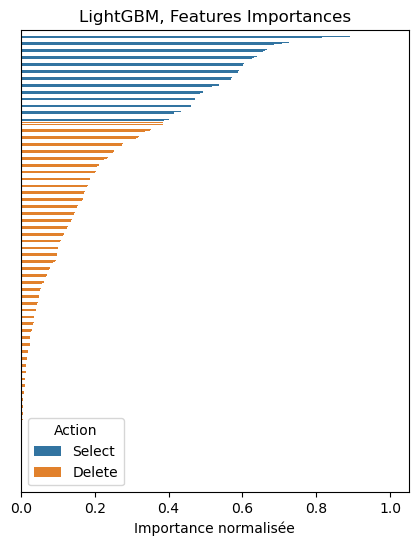

1:1: E265 block comment should start with '# '


In [43]:
#Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_lGBM_selec05,
                 x="lGBM_importance_normalized", y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('LightGBM, Features Importances')
plt.show()

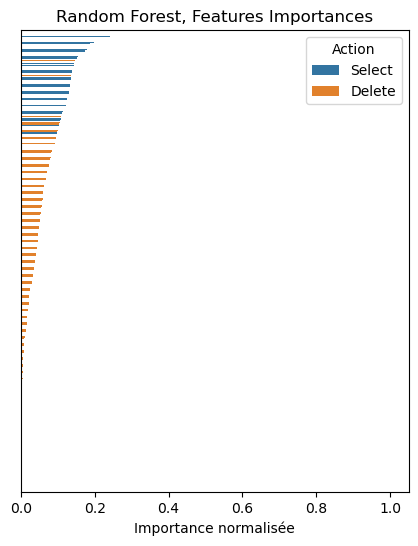

In [44]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_selec05_RF, x="RF_importance_normalized",
                 y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('Random Forest, Features Importances')
plt.show()

In [45]:
train_data_fs_05 = train_data_std.copy()
test_data_fs_05 = test_data_std.copy()

# Remove features with a combined normalized importance under 0.5
train_data_fs_05 = \
        train_data_fs_05.drop(columns=to_remove05['feature'].tolist())
test_data_fs_05 = \
        test_data_fs_05.drop(columns=to_remove05['feature'].tolist())

print(f'train_data : {train_data_fs_05.shape}')
print(f'test_data : {test_data_fs_05.shape}')

train_data : (307511, 78)
test_data : (48744, 78)


**Reconstruct datasets**

In [46]:
train_data_fs_05['TARGET'] = target_train
train_data_fs_05['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data_fs_05.shape}')

test_data_fs_05['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data_fs_05.shape}')

train_data : (307511, 80)
test_data : (48744, 79)


**Saving datasets after feature selection**

In [47]:
# Saving datasets after feature selection ready for ML
path_train_data_feat_select = \
    '../P7_scoring_credit/preprocessing/train_data_fs_05_ML.pkl'
with open(path_train_data_feat_select, 'wb') as f:
    pickle.dump(train_data_fs_05, f, pickle.HIGHEST_PROTOCOL)

In [48]:
# Saving datasets after feature selection ready for ML
path_test_data_feat_select = \
    '../P7_scoring_credit/preprocessing/test_data_fs_05_ML.pkl'
with open(path_test_data_feat_select, 'wb') as f:
    pickle.dump(test_data_fs_05, f, pickle.HIGHEST_PROTOCOL)

<a id='select_combined_normalized_importance_15highest'></a>

### <span style='background:#0075bc'><span style='color:white'>15 highest values of combined normalized importance will be selected</span></span>

In [49]:
df_feat_imp_selec = df_feat_importances.copy()
df_feat_importance_lGBM_selec = df_feat_importance_lGBM.copy()
df_feat_importance_RF_selec = df_feat_importance_RF.copy()

In [50]:
# 15 highest values of combined normalized importance will be selected
to_select_15 = df_feat_imp_selec.sort_values(by="combined_importance",
                                             ascending=False).head(15)
to_select_15.shape
print(f"Selected features", to_select_15.shape[0])

Selected features 15


In [51]:
# Features to remove
to_remove_15 = df_feat_imp_selec.loc[~df_feat_imp_selec.index.isin(
                                        to_select_15.index.tolist())]
print(f"Features to remove", to_remove_15.shape[0])

Features to remove 380


In [52]:
# Prepare data for verification
to_remove_15["Action"] = "Delete"
to_select_15["Action"] = "Select"

features_action_15 = [to_select_15[["feature", "Action"]],
                      to_remove_15[["feature", "Action"]]]
action_features_15 = pd.concat(features_action_15)

df_feat_imp_lGBM_15 = df_feat_imp_lGBM_selec.merge(action_features_15,
                                                   on="feature")
df_feat_imp_RF_15 = df_feat_imp_RF_selec.merge(action_features_15,
                                               on="feature")

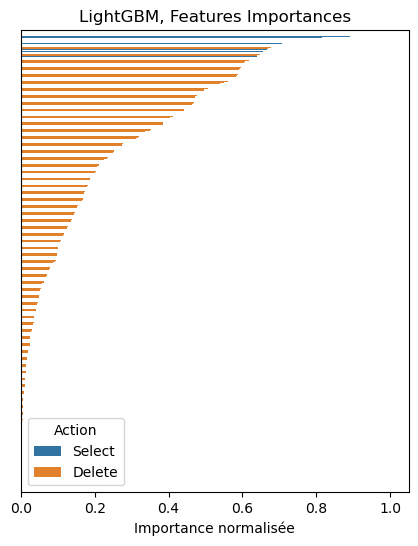

1:1: E265 block comment should start with '# '


In [53]:
#Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_lGBM_15,
                 x="lGBM_importance_normalized", y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('LightGBM, Features Importances')
plt.show()

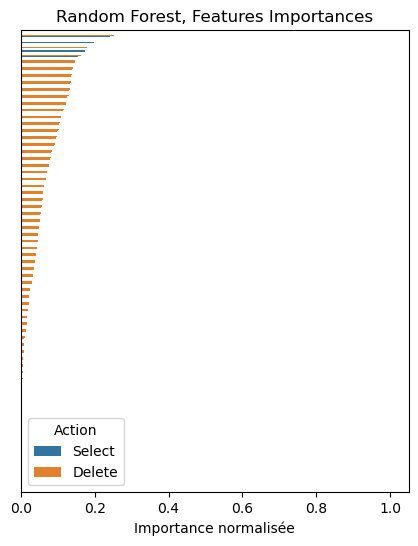

In [54]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_RF_15, x="RF_importance_normalized",
                 y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('Random Forest, Features Importances')
plt.show()

In [55]:
train_data_fs_15 = train_data_std.copy()
test_data_fs_15 = test_data_std.copy()

# Remove features not selected
train_data_fs_15 = \
        train_data_fs_15.drop(columns=to_remove_15['feature'].tolist())
test_data_fs_15 = \
        test_data_fs_15.drop(columns=to_remove_15['feature'].tolist())

print(f'train_data : {train_data_fs_15.shape}')
print(f'test_data : {test_data_fs_15.shape}')

train_data : (307511, 15)
test_data : (48744, 15)


**Reconstruct datasets**

In [56]:
train_data_fs_15['TARGET'] = target_train
train_data_fs_15['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data_fs_15.shape}')

test_data_fs_15['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data_fs_15.shape}')

train_data : (307511, 17)
test_data : (48744, 16)


**Saving datasets after feature selection**

In [57]:
# Saving datasets after feature selection ready for ML
path_train_data_feat_select = \
    '../P7_scoring_credit/preprocessing/train_data_fs_15_ML.pkl'
with open(path_train_data_feat_select, 'wb') as f:
    pickle.dump(train_data_fs_15, f, pickle.HIGHEST_PROTOCOL)

In [58]:
# Saving datasets after feature selection ready for ML
path_test_data_feat_select = \
    '../P7_scoring_credit/preprocessing/test_data_fs_15_ML.pkl'
with open(path_test_data_feat_select, 'wb') as f:
    pickle.dump(test_data_fs_15, f, pickle.HIGHEST_PROTOCOL)

<a id='select_combined_10best_lgbm_rf'></a>

### <span style='background:#0075bc'><span style='color:white'>10 best values of normalized importance from LightGBM and RandomForest will be selected</span></span>

In [59]:
df_feat_imp_selec = df_feat_importances.copy()
df_feat_imp_lGBM_selec = df_feat_importance_lGBM.copy()
df_feat_imp_RF_selec = df_feat_importance_RF.copy()

In [60]:
# 10 highest values of normalized importance will be selected
top_10_lgbm = df_feat_imp_selec.sort_values(by="lGBM_importance_normalized",
                                            ascending=False).head(10)
top_10_rf = df_feat_imp_selec.sort_values(by="RF_importance_normalized",
                                          ascending=False).head(10)

In [61]:
# Lists with the 10 best values for each method
top_10_lgbm_feat = top_10_lgbm["feature"].tolist()
top_10_rf_feat = top_10_rf["feature"].tolist()

# Combine both lists
top_10_rf_but_not_lgbm = set(top_10_rf_feat) - set(top_10_lgbm_feat)
list_top_combined = top_10_lgbm_feat + list(top_10_rf_but_not_lgbm)
print(f'The combination of 10 best results from each method results \
      in the selection of {len(list_top_combined)} features')

top10_combined = df_feat_imp_selec.loc[df_feat_imp_selec["feature"].isin(
                                                        list_top_combined)]

The combination of 10 best results from each method results       in the selection of 16 features


In [62]:
# Features to remove
to_remove_combined_top10 = \
        df_feat_imp_selec.loc[~df_feat_imp_selec.index.isin(
                                            top10_combined.index.tolist())]
print(f"Features to remove", to_remove_combined_top10.shape[0])

Features to remove 379


In [63]:
# Prepare data for verification
to_remove_combined_top10["Action"] = "Delete"
top10_combined["Action"] = "Select"

features_action_combined_top10 = [top10_combined[["feature", "Action"]],
                                  to_remove_combined_top10[["feature",
                                                            "Action"]]]
action_features_combined_top10 = pd.concat(features_action_combined_top10)

df_feat_imp_lGBM_comb_t10 = \
        df_feat_imp_lGBM_selec.merge(action_features_combined_top10,
                                     on="feature")
df_feat_imp_RF_comb_t10 = \
        df_feat_imp_RF_selec.merge(action_features_combined_top10,
                                   on="feature")

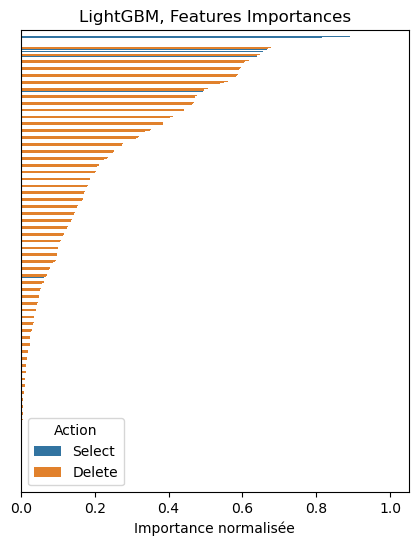

In [64]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_lGBM_comb_t10,
                 x="lGBM_importance_normalized", y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('LightGBM, Features Importances')
plt.show()

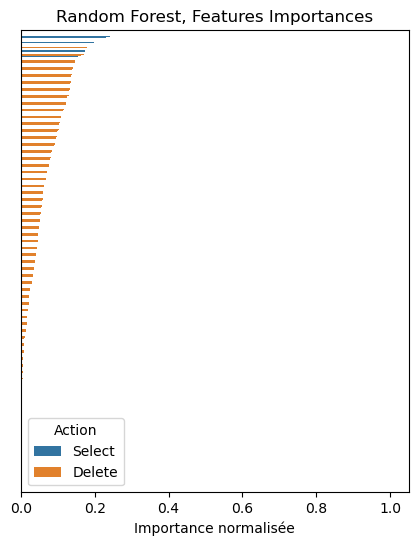

In [65]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_RF_comb_t10, x="RF_importance_normalized",
                 y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('Random Forest, Features Importances')
plt.show()

In [66]:
train_data_fs_top10 = train_data_std.copy()
test_data_fs_top10 = test_data_std.copy()

# Remove features not selected
train_data_fs_top10 = train_data_fs_top10.drop(
                         columns=to_remove_combined_top10['feature'].tolist())

test_data_fs_top10 = test_data_fs_top10.drop(
                      columns=to_remove_combined_top10['feature'].tolist())

print(f'train_data : {train_data_fs_top10.shape}')
print(f'test_data : {test_data_fs_top10.shape}')

train_data : (307511, 16)
test_data : (48744, 16)


**Reconstruct datasets**

In [67]:
train_data_fs_top10['TARGET'] = target_train
train_data_fs_top10['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data_fs_top10.shape}')

test_data_fs_top10['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data_fs_top10.shape}')

train_data : (307511, 18)
test_data : (48744, 17)


**Saving datasets after feature selection**

In [68]:
# Saving datasets after feature selection ready for ML
path_train_data_feat_select = \
    '../P7_scoring_credit/preprocessing/train_data_fs_top10_ML.pkl'
with open(path_train_data_feat_select, 'wb') as f:
    pickle.dump(train_data_fs_top10, f, pickle.HIGHEST_PROTOCOL)

In [69]:
# Saving datasets after feature selection ready for ML
path_test_data_feat_select = \
    '../P7_scoring_credit/preprocessing/test_data_fs_top10_ML.pkl'
with open(path_test_data_feat_select, 'wb') as f:
    pickle.dump(test_data_fs_top10, f, pickle.HIGHEST_PROTOCOL)

<a id='select_combined_25best_lgbm_rf'></a>

### <span style='background:#0075bc'><span style='color:white'>25 best values of normalized importance from LightGBM and RandomForest will be selected</span></span>

In [70]:
df_feat_imp_selec = df_feat_importances.copy()
df_feat_imp_lGBM_selec = df_feat_importance_lGBM.copy()
df_feat_imp_RF_selec = df_feat_importance_RF.copy()

In [71]:
# 25 highest values of normalized importance will be selected
top_25_lgbm = df_feat_imp_selec.sort_values(by="lGBM_importance_normalized",
                                            ascending=False).head(25)
top_25_rf = df_feat_imp_selec.sort_values(by="RF_importance_normalized",
                                          ascending=False).head(25)

In [72]:
# Lists with the 25 best values for each method
top_25_lgbm_feat = top_25_lgbm["feature"].tolist()
top_25_rf_feat = top_25_rf["feature"].tolist()

# Combine both lists
top_25_rf_but_not_lgbm = set(top_25_rf_feat) - set(top_25_lgbm_feat)
list_top25_combined = top_25_lgbm_feat + list(top_25_rf_but_not_lgbm)
print(f'The combination of 25 best results from each method results in \
    the selection of {len(list_top25_combined)} features')

top25_combined = df_feat_imp_selec.loc[df_feat_imp_selec["feature"]
                                       .isin(list_top25_combined)]

The combination of 25 best results from each method results in     the selection of 34 features


In [73]:
# Features to remove
to_remove_combined_t25 = df_feat_imp_selec.loc[~df_feat_imp_selec.index
                                        .isin(top25_combined.index.tolist())]
print(f"Features to remove", to_remove_combined_t25.shape[0])

Features to remove 361


3:41: E128 continuation line under-indented for visual indent


In [74]:
# Prepare data for verification
to_remove_combined_t25["Action"] = "Delete"
top25_combined["Action"] = "Select"

features_action_combined_t25 = [top25_combined[["feature", "Action"]],
                                to_remove_combined_t25[["feature",
                                                        "Action"]]]
action_features_combined_t25 = pd.concat(features_action_combined_t25)

df_feat_imp_lGBM_comb_t25 = \
            df_feat_imp_lGBM_selec.merge(action_features_combined_t25,
                                         on="feature")
df_feat_imp_RF_comb_t25 = \
            df_feat_imp_RF_selec.merge(action_features_combined_t25,
                                       on="feature")

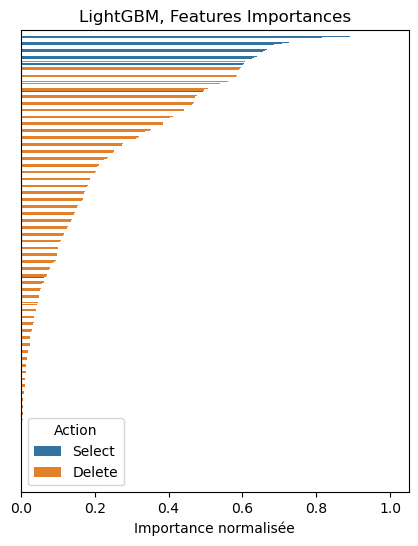

In [75]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_lGBM_comb_t25,
                 x="lGBM_importance_normalized", y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('LightGBM, Features Importances')
plt.show()

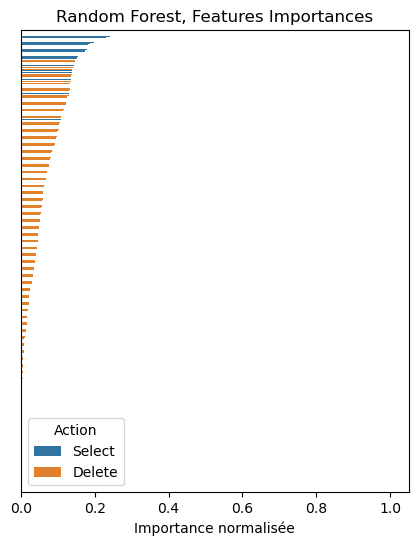

In [76]:
# Graphic representation of selected features
plt.figure(figsize=(5, 6))

ax = sns.barplot(data=df_feat_imp_RF_comb_t25, x="RF_importance_normalized",
                 y="feature", hue="Action")
ax.set_ylabel(None)
ax.set_yticks([])

plt.xlabel('Importance normalisée')
plt.title('Random Forest, Features Importances')
plt.show()

In [77]:
train_data_fs_t25 = train_data_std.copy()
test_data_fs_t25 = test_data_std.copy()

# Remove features not selected
train_data_fs_t25 = train_data_fs_t25.drop(
                        columns=to_remove_combined_t25['feature'].tolist())
test_data_fs_t25 = test_data_fs_t25.drop(
                        columns=to_remove_combined_t25['feature'].tolist())

print(f'train_data : {train_data_fs_t25.shape}')
print(f'test_data : {test_data_fs_t25.shape}')

train_data : (307511, 34)
test_data : (48744, 34)


**Reconstruct datasets**

In [78]:
train_data_fs_t25['TARGET'] = target_train
train_data_fs_t25['SK_ID_CURR'] = skid_train
print(f'train_data : {train_data_fs_t25.shape}')

test_data_fs_t25['SK_ID_CURR'] = skid_test
print(f'test_data : {test_data_fs_t25.shape}')

train_data : (307511, 36)
test_data : (48744, 35)


**Saving datasets after feature selection**

In [79]:
# Saving datasets after feature selection ready for ML
path_train_data_feat_select = \
    '../P7_scoring_credit/preprocessing/train_data_fs_t25_combi_ML.pkl'
with open(path_train_data_feat_select, 'wb') as f:
    pickle.dump(train_data_fs_t25, f, pickle.HIGHEST_PROTOCOL)

In [80]:
# Saving datasets after feature selection ready for ML
path_test_data_feat_select = \
    '../P7_scoring_credit/preprocessing/test_data_fs_t25_combi_ML.pkl'
with open(path_test_data_feat_select, 'wb') as f:
    pickle.dump(test_data_fs_t25, f, pickle.HIGHEST_PROTOCOL)

<a id='feat_select_summary'></a>

## <span style='background:#0085dd'><span style='color:white'>Summary</span></span>

Several variable selection strategies have been tested.<br>
The feature importances generated by linear and non-linear algorithms are different. In order to integrate the use of the variables obtained by both algorithm families, the importances have been normalised.<br>
The strategy offering the best results (compromise between computation time and performance preservation) consists in considering the 25 most important feature importances for LightGBM and the 25 most important for Random Forest. In total 34 variables are retained for modelling.